## Import Libraries

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from scipy import stats

# Configure plotting
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# Display options
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 3)

## Load Data

In [20]:
# Load pre-period features
features_df = pd.read_csv('../data/store_preperiod_features.csv')

# Load full sales data
df = pd.read_csv('../data/store_weekly_sales.csv')

print(f"Loaded features for {len(features_df)} stores")
print(f"Loaded {len(df):,} store-week observations")
print(f"\nFeatures available:")
print(features_df.columns.tolist())
print(f"\nFirst few rows:")
features_df.head()

Loaded features for 200 stores
Loaded 20,800 store-week observations

Features available:
['store_id', 'pre_slope', 'pre_avg_sales', 'pre_sales_std', 'pre_cv', 'treatment']

First few rows:


,store_id,pre_slope,pre_avg_sales,pre_sales_std,pre_cv,treatment
0,STORE_001,209.985,94213.636,16504.675,0.175,0
1,STORE_002,9.046,93900.288,15237.331,0.162,1
2,STORE_003,1063.644,127332.277,25332.164,0.199,1
3,STORE_004,695.201,114587.751,20382.878,0.178,0
4,STORE_005,7.204,114378.208,14108.651,0.123,0


## Prepare Features for Clustering

We'll use three pre-period features:
- **Slope**: Sales trend (growth/decline)
- **Average Sales**: Store size/scale
- **Volatility**: Sales variability (standard deviation)

In [21]:
# Select features for clustering
clustering_features = ['pre_slope', 'pre_avg_sales', 'pre_sales_std']

X = features_df[clustering_features].values

print("Features for clustering:")
print(features_df[clustering_features].describe())

# Check for any missing values
print(f"\nMissing values: {features_df[clustering_features].isnull().sum().sum()}")

Features for clustering:
       pre_slope  pre_avg_sales  pre_sales_std
count    200.000        200.000        200.000
mean     353.744     112665.628      18230.415
std      332.018      22569.874       4538.615
min     -508.027      64504.272       8105.106
25%      104.577      94906.603      15412.059
50%      343.197     112057.633      17747.944
75%      546.237     128277.272      21284.445
max     1448.717     178755.187      34107.774

Missing values: 0


## Standardize Features

Standardization is critical because:
- Features have different scales (slope in $, sales in $10,000s)
- KMeans is sensitive to feature magnitudes
- Ensures each feature contributes equally to distance calculations

In [22]:
# Standardize features (mean=0, std=1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Create DataFrame for easier analysis
X_scaled_df = pd.DataFrame(
    X_scaled, 
    columns=[f'{col}_scaled' for col in clustering_features],
    index=features_df.index
)

print("Standardized features:")
print(X_scaled_df.describe())

# Verify standardization
print(f"\nMeans (should be ~0): {X_scaled.mean(axis=0)}")
print(f"Std devs (should be ~1): {X_scaled.std(axis=0)}")

Standardized features:
       pre_slope_scaled  pre_avg_sales_scaled  pre_sales_std_scaled
count         2.000e+02             2.000e+02             2.000e+02
mean          8.882e-17             9.326e-17             4.086e-16
std           1.003e+00             1.003e+00             1.003e+00
min          -2.602e+00            -2.139e+00            -2.237e+00
25%          -7.523e-01            -7.888e-01            -6.225e-01
50%          -3.184e-02            -2.701e-02            -1.066e-01
75%           5.812e-01             6.934e-01             6.746e-01
max           3.306e+00             2.936e+00             3.507e+00

Means (should be ~0): [8.88178420e-17 9.32587341e-17 4.08562073e-16]
Std devs (should be ~1): [1. 1. 1.]


## Apply KMeans Clustering (k=3)

We choose 3 clusters to represent:
- **Declining stores**: Negative pre-period slope
- **Stable stores**: Near-zero pre-period slope
- **Growing stores**: Positive pre-period slope

In [23]:
# Set random seed for reproducibility
np.random.seed(42)

# Fit KMeans
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_scaled)

# Add cluster assignments to features DataFrame
features_df['cluster'] = clusters

print(f"KMeans clustering complete with {n_clusters} clusters")
print(f"\nCluster sizes:")
print(features_df['cluster'].value_counts().sort_index())

# Show inertia (sum of squared distances to nearest cluster center)
print(f"\nInertia: {kmeans.inertia_:.2f}")

KMeans clustering complete with 3 clusters

Cluster sizes:
cluster
0    40
1    84
2    76
Name: count, dtype: int64

Inertia: 215.17


## Analyze Cluster Characteristics

Examine the average features within each cluster to understand what makes them distinct.

In [24]:
# Calculate cluster statistics
cluster_stats = features_df.groupby('cluster')[clustering_features].agg(['mean', 'std', 'min', 'max'])

print("Cluster Characteristics:")
print("="*80)
print(cluster_stats)

# Also show cluster centers (in original scale)
print("\nCluster Centers (original scale):")
print("="*80)
cluster_centers_original = scaler.inverse_transform(kmeans.cluster_centers_)
centers_df = pd.DataFrame(
    cluster_centers_original,
    columns=clustering_features,
    index=[f'Cluster {i}' for i in range(n_clusters)]
)
print(centers_df)

Cluster Characteristics:
        pre_slope                             pre_avg_sales             \
             mean      std      min       max          mean        std   
cluster                                                                  
0         805.983  235.984  464.191  1448.717    138465.762  16517.749   
1         300.937  261.978 -508.027   806.073    120505.869  11835.680   
2         174.088  206.579 -257.681   632.511     90421.081  11376.764   

                                pre_sales_std                                  
                min         max          mean       std        min        max  
cluster                                                                        
0        110872.090  178755.187     24826.908  3297.484  20113.807  34107.774  
1         98123.216  157042.579     18805.255  1873.483  14524.074  23954.583  
2         64504.272  114378.208     14123.227  2108.613   8105.106  18087.844  

Cluster Centers (original scale):
           pre_

## Label Clusters Based on Trend Direction

Assign meaningful names based on average pre-period slope.

In [25]:
# Calculate mean slope for each cluster
cluster_slopes = features_df.groupby('cluster')['pre_slope'].mean().sort_values()

print("Mean slope by cluster:")
print(cluster_slopes)

# Create mapping based on slope ordering
# Cluster with most negative slope = Declining
# Cluster with most positive slope = Growing  
# Middle cluster = Stable
slope_order = cluster_slopes.index.tolist()

cluster_labels = {
    slope_order[0]: 'Declining',
    slope_order[1]: 'Stable',
    slope_order[2]: 'Growing'
}

# Add labels to DataFrame
features_df['segment'] = features_df['cluster'].map(cluster_labels)

print("\nCluster Labels:")
for cluster, label in cluster_labels.items():
    n_stores = (features_df['cluster'] == cluster).sum()
    avg_slope = features_df[features_df['cluster'] == cluster]['pre_slope'].mean()
    print(f"  Cluster {cluster} → '{label}': {n_stores} stores, avg slope = {avg_slope:.2f} $/week")

# Show segment distribution
print("\nSegment distribution:")
print(features_df['segment'].value_counts())

Mean slope by cluster:
cluster
2    174.088
1    300.937
0    805.983
Name: pre_slope, dtype: float64

Cluster Labels:
  Cluster 2 → 'Declining': 76 stores, avg slope = 174.09 $/week
  Cluster 1 → 'Stable': 84 stores, avg slope = 300.94 $/week
  Cluster 0 → 'Growing': 40 stores, avg slope = 805.98 $/week

Segment distribution:
segment
Stable       84
Declining    76
Growing      40
Name: count, dtype: int64


## Segment Summary Table

Create a comprehensive summary showing key characteristics of each segment.

In [26]:
# Create comprehensive segment summary
segment_summary = features_df.groupby('segment').agg({
    'store_id': 'count',
    'pre_slope': 'mean',
    'pre_avg_sales': 'mean',
    'pre_sales_std': 'mean',
    'pre_cv': 'mean'
}).round(2)

# Rename columns for clarity
segment_summary.columns = [
    'Number of Stores',
    'Avg Weekly Slope ($/week)',
    'Avg Weekly Sales ($)',
    'Avg Sales Volatility ($)',
    'Avg Coefficient of Variation'
]

# Reorder segments
segment_order = ['Declining', 'Stable', 'Growing']
segment_summary = segment_summary.reindex(segment_order)

print("Segment Summary Table")
print("="*100)
print(segment_summary)
print()

# Add percentage of total stores
total_stores = segment_summary['Number of Stores'].sum()
segment_summary['% of Total'] = (segment_summary['Number of Stores'] / total_stores * 100).round(1)

print("\nSegment Summary with Percentages")
print("="*100)
print(segment_summary)

Segment Summary Table
           Number of Stores  Avg Weekly Slope ($/week)  Avg Weekly Sales ($)  \
segment                                                                        
Declining                76                     174.09              90421.08   
Stable                   84                     300.94             120505.87   
Growing                  40                     805.98             138465.76   

           Avg Sales Volatility ($)  Avg Coefficient of Variation  
segment                                                            
Declining                  14123.23                          0.16  
Stable                     18805.25                          0.16  
Growing                    24826.91                          0.18  


Segment Summary with Percentages
           Number of Stores  Avg Weekly Slope ($/week)  Avg Weekly Sales ($)  \
segment                                                                        
Declining                76               

## Business Interpretation of Segments

### 📉 Declining Segment
**Characteristics:**
- **Negative pre-period sales slope**: These stores were experiencing declining sales trends before the pilot
- **Sales trajectory**: Downward trend indicates potential market challenges, increased competition, or operational issues
- **Business implication**: These stores may be struggling and could benefit most from interventions like the new layout

**Why this matters for A/B testing:**
- If treatment is effective, we expect to see trend reversal or slower decline
- Comparing treatment vs control within this segment isolates the pilot effect from the underlying decline
- Without segmentation, declining stores could bias overall results downward

---

### ⚖️ Stable Segment
**Characteristics:**
- **Near-zero pre-period slope**: Sales remained relatively flat before the pilot
- **Sales trajectory**: Steady state indicates mature, established stores with consistent performance
- **Business implication**: These stores represent the "typical" baseline - neither growing nor declining

**Why this matters for A/B testing:**
- Easiest segment to analyze since pre-period trend is minimal
- Treatment effect is most directly observable (any lift is likely due to intervention)
- Provides a clean comparison for traditional pre-post analysis

---

### 📈 Growing Segment
**Characteristics:**
- **Positive pre-period slope**: These stores were already experiencing growth before the pilot
- **Sales trajectory**: Upward trend indicates strong market position, effective operations, or favorable demographics
- **Business implication**: High-performing stores that may have less room for improvement (ceiling effect)

**Why this matters for A/B testing:**
- If treatment is effective, we expect accelerated growth beyond the natural trend
- Comparing treatment vs control within this segment separates pilot impact from organic growth
- Without segmentation, growing stores could inflate overall results and hide true treatment effect

---

### Key Insight
By segmenting stores and analyzing treatment effects **within each segment**, we control for pre-existing trends that could confound our results. This is crucial when stores have heterogeneous growth trajectories.

## Verify Treatment Balance Within Segments

Check that treatment/control are balanced within each segment.

In [27]:
# Cross-tabulation of segment and treatment
balance_table = pd.crosstab(
    features_df['segment'], 
    features_df['treatment'],
    margins=True
)
balance_table.columns = ['Control', 'Treatment', 'Total']

print("Treatment Balance by Segment:")
print("="*60)
print(balance_table)

# Calculate treatment percentage within each segment
print("\nTreatment % by Segment:")
for segment in ['Declining', 'Stable', 'Growing']:
    segment_data = features_df[features_df['segment'] == segment]
    pct_treatment = segment_data['treatment'].mean() * 100
    print(f"  {segment}: {pct_treatment:.1f}%")

Treatment Balance by Segment:
           Control  Treatment  Total
segment                             
Declining       63         13     76
Growing         25         15     40
Stable          62         22     84
All            150         50    200

Treatment % by Segment:
  Declining: 17.1%
  Stable: 26.2%
  Growing: 37.5%


## Visualize Clusters

Plot stores in 2D feature space to visualize cluster separation.

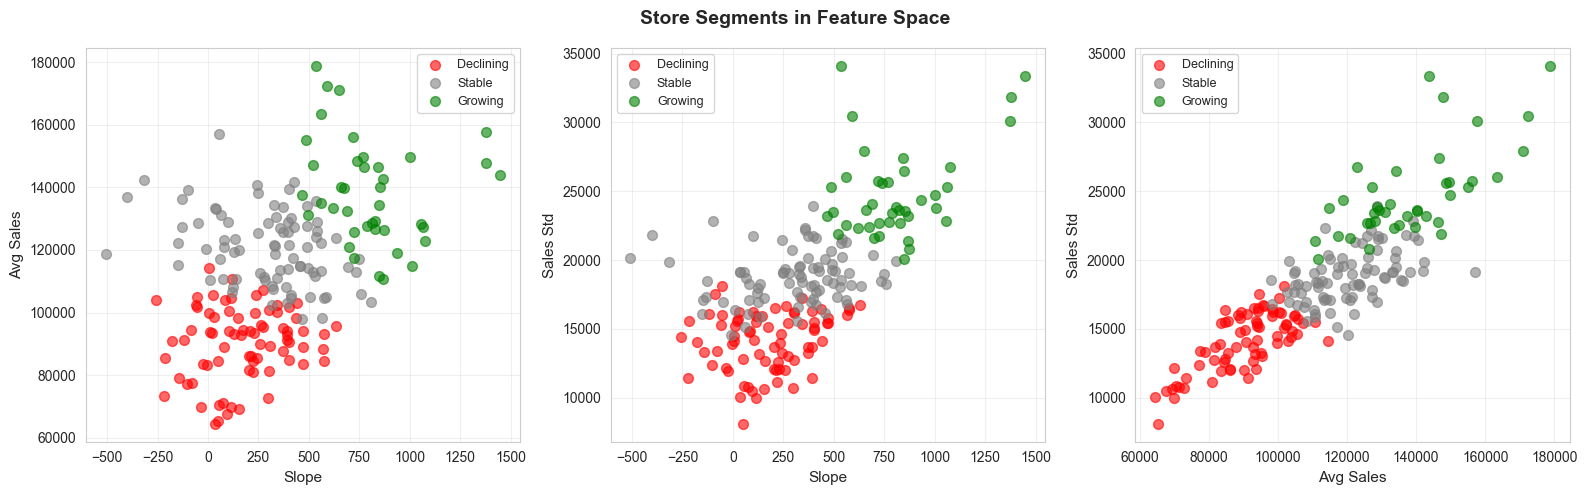

In [ ]:
# Create pairwise scatter plots
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

feature_pairs = [
    ('pre_slope', 'pre_avg_sales'),
    ('pre_slope', 'pre_sales_std'),
    ('pre_avg_sales', 'pre_sales_std')
]

colors = {'Declining': 'red', 'Stable': 'gray', 'Growing': 'green'}

for idx, (feat1, feat2) in enumerate(feature_pairs):
    ax = axes[idx]
    
    for segment, color in colors.items():
        segment_data = features_df[features_df['segment'] == segment]
        ax.scatter(segment_data[feat1], segment_data[feat2], 
                  c=color, label=segment, alpha=0.6, s=50)
    
    ax.set_xlabel(feat1.replace('pre_', '').replace('_', ' ').title(), fontsize=11)
    ax.set_ylabel(feat2.replace('pre_', '').replace('_', ' ').title(), fontsize=11)
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)

plt.suptitle('Store Segments in Feature Space', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('../reports/figures/segment_feature_space.png', dpi=300, bbox_inches='tight')
plt.show()

## Distribution of Slopes by Segment

C:\Users\ddron\AppData\Local\Temp\ipykernel_26904\3085893553.py:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(segment_data, labels=segments_ordered, patch_artist=True)


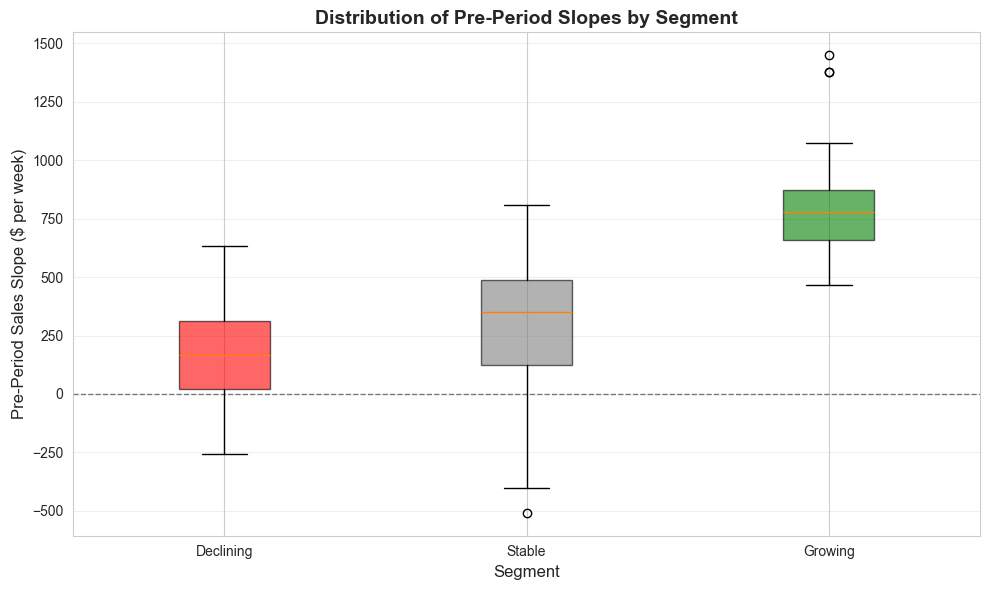


Slope Statistics by Segment:
           count     mean      std      min      25%      50%      75%  \
segment                                                                  
Declining   76.0  174.088  206.579 -257.681   23.115  166.546  314.163   
Growing     40.0  805.983  235.984  464.191  658.001  779.719  870.162   
Stable      84.0  300.937  261.978 -508.027  124.391  351.166  488.857   

                max  
segment              
Declining   632.511  
Growing    1448.717  
Stable      806.073  


In [29]:
# Box plot of slopes by segment
fig, ax = plt.subplots(figsize=(10, 6))

segments_ordered = ['Declining', 'Stable', 'Growing']
segment_data = [features_df[features_df['segment'] == seg]['pre_slope'] for seg in segments_ordered]

bp = ax.boxplot(segment_data, labels=segments_ordered, patch_artist=True)

# Color the boxes
for patch, color in zip(bp['boxes'], ['red', 'gray', 'green']):
    patch.set_facecolor(color)
    patch.set_alpha(0.6)

ax.set_ylabel('Pre-Period Sales Slope ($ per week)', fontsize=12)
ax.set_xlabel('Segment', fontsize=12)
ax.set_title('Distribution of Pre-Period Slopes by Segment', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')
ax.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nSlope Statistics by Segment:")
print(features_df.groupby('segment')['pre_slope'].describe())

## Save Segmented Data

## Segment-Level Treatment Effect Analysis

Now that we have stores grouped into segments, we'll estimate treatment effects **within each segment** using a difference-in-differences approach.

In [30]:
# Define treatment start week
TREATMENT_START_WEEK = 53

# Compute pre and post period average sales for each store
store_period_sales = []

for store_id in features_df['store_id'].unique():
    store_data = df[df['store_id'] == store_id]
    
    # Pre-period average
    pre_sales = store_data[store_data['week'] < TREATMENT_START_WEEK]['sales'].mean()
    
    # Post-period average
    post_sales = store_data[store_data['week'] >= TREATMENT_START_WEEK]['sales'].mean()
    
    # Get segment and treatment info
    segment = features_df[features_df['store_id'] == store_id]['segment'].values[0]
    treatment = features_df[features_df['store_id'] == store_id]['treatment'].values[0]
    
    store_period_sales.append({
        'store_id': store_id,
        'segment': segment,
        'treatment': treatment,
        'pre_sales': pre_sales,
        'post_sales': post_sales,
        'change': post_sales - pre_sales,
        'pct_change': (post_sales - pre_sales) / pre_sales * 100
    })

period_df = pd.DataFrame(store_period_sales)

print("Store-Level Pre-Post Sales Summary:")
print(period_df.head(10))

Store-Level Pre-Post Sales Summary:
    store_id    segment  treatment   pre_sales  post_sales     change  \
0  STORE_001  Declining          0   94213.636  109437.019  15223.382   
1  STORE_002  Declining          1   93900.288  106609.887  12709.599   
2  STORE_003    Growing          1  127332.277  203004.502  75672.226   
3  STORE_004     Stable          0  114587.751  149749.226  35161.475   
4  STORE_005  Declining          0  114378.208  113029.462  -1348.747   
5  STORE_006  Declining          0   81069.722   91003.605   9933.883   
6  STORE_007     Stable          0   98168.229  130303.620  32135.391   
7  STORE_008     Stable          0  117149.060  117682.388    533.328   
8  STORE_009  Declining          0   93168.073  122717.341  29549.267   
9  STORE_010    Growing          1  146526.340  199024.972  52498.631   

   pct_change  
0      16.158  
1      13.535  
2      59.429  
3      30.685  
4      -1.179  
5      12.254  
6      32.735  
7       0.455  
8      31.716  


In [31]:
# Save features with cluster assignments
output_path = '../data/store_segments.csv'
features_df.to_csv(output_path, index=False)

print(f"Saved segmented data to: {output_path}")
print(f"\nColumns saved:")
for col in features_df.columns:
    print(f"  - {col}")

print("\n✓ Segmentation complete!")

Saved segmented data to: ../data/store_segments.csv

Columns saved:
  - store_id
  - pre_slope
  - pre_avg_sales
  - pre_sales_std
  - pre_cv
  - treatment
  - cluster
  - segment

✓ Segmentation complete!
